In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, classification_report
from sklearn.feature_selection import RFE

# Load the data (assuming 'data' is already a pandas dataframe)
data = pd.read_csv('../in/optipaw_FINAL.csv')  # Load your data here
data = data.set_index('Animal.ID')

In [2]:
data

,Name,Animal.Type,Breed,Sex,Color,Age,Intake.Type,Outcome.Type,Intake.Date,Outcome.Date,State
Animal.ID,,,,,,,,,,,
A006100,Scamp,Dog,Spinone Italiano Mix,Neutered Male,Yellow/White,7.00,Public Assist,Return to Owner,2014-12-19 10:21:00,2014-12-20 16:35:00,Austin
A006100,Scamp,Dog,Spinone Italiano Mix,Neutered Male,Yellow/White,6.00,Public Assist,Return to Owner,2014-03-07 14:26:00,2014-03-08 17:10:00,Austin
A047759,Oreo,Dog,Dachshund,Neutered Male,Tricolor,10.00,Owner Surrender,Transfer,2014-04-02 15:55:00,2014-04-07 15:12:00,Austin
A134067,Bandit,Dog,Shetland Sheepdog,Neutered Male,Brown/White,16.00,Public Assist,Return to Owner,2013-11-16 09:02:00,2013-11-16 11:54:00,Austin
A141142,Bettie,Dog,Labrador Retriever/Pit Bull,Spayed Female,Black/White,15.00,Stray,Return to Owner,2013-11-16 14:46:00,2013-11-17 11:40:00,Austin
...,...,...,...,...,...,...,...,...,...,...,...
64574,Maeve,Cat,Domestic Short Hair,Female,Tabbico,0.50,Litter relinquishment,Adoption,2019-08-26 16:48:35,2019-08-30,Indiana
64582,Whiskers,Cat,Domestic Short Hair,Male,Grey,0.31,Allergies,Adoption,2019-08-27 16:12:00,2019-08-30,Indiana
64584,Max,Cat,Domestic Medium Hair,Male,Orange and White,0.40,Litter relinquishment,Adoption,2019-08-27 16:52:09,2019-08-29,Indiana


In [3]:
# Important note: preprocessing doesn't delete the Animal ID, you have to manually delete later on, reason is to preserve it
# as a variable for scoring
def preprocessing(df, name_mapping_var=None):

  # For Name, we will use label encoding to assign each unique name a specific int, at the same time return the mapping
  # Strip leading asterisks from the Name column
  df['Name'] = df['Name'].str.lstrip('*')
  label_encoder = LabelEncoder()
  df['Name'] = label_encoder.fit_transform(df['Name'].astype(str))

  # If the user provided a variable to store the mapping, assign it
  if name_mapping_var is not None:
      name_mapping = {k: v for v, k in enumerate(label_encoder.classes_)}
      name_mapping_var.update(name_mapping)


  # For Animal.Type we will map Int Values to the specific animal type
  animal_mapping = {
    "Dog": 1, "Cat": 2, "Other": 3, "Bird": 4, "Livestock": 5,
    "House Rabbit": 6, "Rat": 7, "Ferret": 8, "Pig": 9, "Hamster": 10,
    "Guinea Pig": 11, "Gerbil": 12, "Hedgehog": 13, "Chinchilla": 14,
    "Goat": 15, "Mouse": 16, "Sugar Glider": 17, "Snake": 18,
    "Wildlife": 19, "Lizard": 20
    }

  df['Animal.Type'] = df['Animal.Type'].map(animal_mapping)

  # For Breed we will perform one hot encoding onto it
  # Remove parentheses and their contents, and replace '/' with space
  df['Breed'] = df['Breed'].str.replace(r'\(.*?\)', '', regex=True).str.replace('/', ' ').str.replace(',', ' ')

  # Split the 'Breed' column into a list and capitalize the first letter of each word
  df['Breed'] = df['Breed'].str.split().apply(lambda breeds: [breed.rstrip('-').capitalize() for breed in breeds])

  # Create dummy variables for each unique breed
  df_breeds = df['Breed'].str.join(' ').str.get_dummies(sep=' ')

  # Concatenate the original dataframe with the one-hot encoded breed dataframe
  df = pd.concat([df, df_breeds], axis=1)

  # Drop the original 'Breed' column
  df = df.drop(columns=['Breed'])

  # For Sex we will map Int Values to specific Sex
  sex_mapping = {'Neutered Male': 1, 'Spayed Female': 2, 'Intact Female': 3, 'Intact Male': 4, 'Unknown': 5, 'Female': 6, 'Male': 7}

  # Map the Sex column using the defined mapping
  df['Sex'] = df['Sex'].map(sex_mapping)

  # For colours, we will split into individual colours and use one hot encoding, which is assigning binary values to it

  # Split the 'Color' column by '/', 'and', and ','
  df['Color'] = df['Color'].str.replace('/', ' ').str.replace('and', ' ').str.replace(',', ' ').str.replace(r'-\b', '', regex=True)

  # Split the 'Color' column into a list and capitalize the first letter of each word
  df['Color'] = df['Color'].str.split().apply(lambda colors: [color.capitalize() for color in colors])

  # Create dummy variables for each unique color
  df_colors = df['Color'].str.join(' ').str.get_dummies(sep=' ')

  # Concatenate the original dataframe with the one-hot encoded color dataframe
  df = pd.concat([df, df_colors], axis=1)

  # Drop the original 'Color' column
  df = df.drop(columns=['Color'])

  # For Age, we will just store it as int and impute it with 0 if it is null, and store it as float
  df['Age'] = df['Age'].fillna(0).astype(float)

  # For Intake.Type, we will map Int Values to specific Intake
  intake_type_mapping = {
      'Public Assist': 1, 'Owner Surrender': 2, 'Stray': 3, 'Euthanasia Request': 4,
      'Abandoned': 5, 'Wildlife': 6, 'Moving': 7, 'Incompatible with owner lifestyle': 8,
      'Rabies Monitoring': 9, 'Marriage/Relationship split': 10, 'Owner Deceased': 11, 'Police Assist': 12,
      'Biting': 13, 'Owner Died': 14, 'TNR - Trap/Neuter/Release': 15, 'Unable to Afford': 16,
      'Unsuitable Accommodation': 17, 'Allergies': 18, 'Transfer from Other Shelter': 19,
      'Born in Shelter': 20, 'Landlord issues': 21, 'Litter relinquishment': 22, 'Sick/Injured': 23,
      'Owner requested Euthanasia': 24, 'Abuse/ neglect': 25, 'Incompatible with other pets': 26,
      'Behavioral Issues': 27, 'DOA': 28
  }

  # Map the Intake.Type column using the defined mapping
  df['Intake.Type'] = df['Intake.Type'].map(intake_type_mapping)

  # For Outcome.Type, we will map Int Values to specific Outcome
  outcome_type_mapping = {
      'Return to Owner': 1, 'Transfer': 2, 'Adoption': 3, 'Euthanasia': 4,
      'Died': 5, 'Rto-Adopt': 6, 'Disposal': 7, 'Missing': 8,
      'Stolen': 9, 'Relocate': 10, 'Lost': 11, 'Foster': 12,
      'Reclaimed': 13, 'Escaped': 14, 'Released To Wild': 15
  }

  # Map the Outcome.Type column using the defined mapping
  df['Outcome.Type'] = df['Outcome.Type'].map(outcome_type_mapping)

  # For Date and Time, we will be using panda and numpy date conversion

  # Convert Intake.Date and Outcome.Date to datetime format
  df['Intake.Date'] = pd.to_datetime(df['Intake.Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
  df['Outcome.Date'] = pd.to_datetime(df['Outcome.Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


  # Extract date components from the date columns
  df['Intake.Day'] = df['Intake.Date'].dt.day.fillna(0).astype(int)
  df['Intake.Month'] = df['Intake.Date'].dt.month.fillna(0).astype(int)
  df['Intake.Year'] = df['Intake.Date'].dt.year.fillna(0).astype(int)

  df['Outcome.Day'] = df['Outcome.Date'].dt.day.fillna(0).astype(int)
  df['Outcome.Month'] = df['Outcome.Date'].dt.month.fillna(0).astype(int)
  df['Outcome.Year'] = df['Outcome.Date'].dt.year.fillna(0).astype(int)

  # Extract and convert the hour to radians
  df['Intake.Hour'] = df['Intake.Date'].dt.hour.fillna(0).astype(int)
  df['Outcome.Hour'] = df['Outcome.Date'].dt.hour.fillna(0).astype(int)

  df['Intake.Hour.Radians'] = (df['Intake.Hour'] / 24) * 2 * np.pi
  df['Outcome.Hour.Radians'] = (df['Outcome.Hour'] / 24) * 2 * np.pi
  # df['Days.Stay'] = (df['Outcome.Date'] - df['Intake.Date']).dt.days

  # Drop original date columns if no longer needed
  df = df.drop(columns=['Intake.Date', 'Outcome.Date'])

  return df

# Process Optipaw Dataset (Animal ID and State to be removed later)
optipaw_data = preprocessing(data)

print(optipaw_data.head())


            Name  Animal.Type  Sex   Age  Intake.Type  Outcome.Type   State  \
Animal.ID                                                                     
A006100    20767            1    1   7.0            1             1  Austin   
A006100    20767            1    1   6.0            1             1  Austin   
A047759    17869            1    1  10.0            2             2  Austin   
A134067     4749            1    1  16.0            1             1  Austin   
A141142     5210            1    2  15.0            3             1  Austin   

           Abyssinian  Affenpinscher  Afghan  ...  Intake.Day  Intake.Month  \
Animal.ID                                     ...                             
A006100             0              0       0  ...          19            12   
A006100             0              0       0  ...           7             3   
A047759             0              0       0  ...           2             4   
A134067             0              0       0  ...  

In [4]:
optipaw_data

,Name,Animal.Type,Sex,Age,Intake.Type,Outcome.Type,State,Abyssinian,Affenpinscher,Afghan,...,Intake.Day,Intake.Month,Intake.Year,Outcome.Day,Outcome.Month,Outcome.Year,Intake.Hour,Outcome.Hour,Intake.Hour.Radians,Outcome.Hour.Radians
Animal.ID,,,,,,,,,,,,,,,,,,,,,
A006100,20767,1,1,7.00,1,1,Austin,0,0,0,...,19,12,2014,20,12,2014,10,16,2.617994,4.188790
A006100,20767,1,1,6.00,1,1,Austin,0,0,0,...,7,3,2014,8,3,2014,14,17,3.665191,4.450590
A047759,17869,1,1,10.00,2,2,Austin,0,0,0,...,2,4,2014,7,4,2014,15,15,3.926991,3.926991
A134067,4749,1,1,16.00,1,1,Austin,0,0,0,...,16,11,2013,16,11,2013,9,11,2.356194,2.879793
A141142,5210,1,2,15.00,3,1,Austin,0,0,0,...,16,11,2013,17,11,2013,14,11,3.665191,2.879793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64574,15169,2,6,0.50,22,3,Indiana,0,0,0,...,26,8,2019,30,8,2019,16,0,4.188790,0.000000
64582,24251,2,7,0.31,18,3,Indiana,0,0,0,...,27,8,2019,30,8,2019,16,0,4.188790,0.000000
64584,15669,2,7,0.40,22,3,Indiana,0,0,0,...,27,8,2019,29,8,2019,16,0,4.188790,0.000000


In [5]:

# optipaw_data = optipaw_data.drop(columns=['Animal.ID'])

In [6]:


train_data = optipaw_data[optipaw_data['State'] == 'Austin']  # Training set with state A
test_data = optipaw_data[optipaw_data['State'] == 'Indiana']   # Test set with state B

# Separate features and target
X_train = train_data.drop(columns=['Outcome.Type', 'State'])  # Features for training
y_train = train_data['Outcome.Type']  # Target for training

X_test = test_data.drop(columns=['Outcome.Type', 'State'])  # Features for testing
y_test = test_data['Outcome.Type']  # Target for testing

In [7]:
X_train

,Name,Animal.Type,Sex,Age,Intake.Type,Abyssinian,Affenpinscher,Afghan,African,Airedale,...,Intake.Day,Intake.Month,Intake.Year,Outcome.Day,Outcome.Month,Outcome.Year,Intake.Hour,Outcome.Hour,Intake.Hour.Radians,Outcome.Hour.Radians
Animal.ID,,,,,,,,,,,,,,,,,,,,,
A006100,20767,1,1,7.00,1,0,0,0,0,0,...,19,12,2014,20,12,2014,10,16,2.617994,4.188790
A006100,20767,1,1,6.00,1,0,0,0,0,0,...,7,3,2014,8,3,2014,14,17,3.665191,4.450590
A047759,17869,1,1,10.00,2,0,0,0,0,0,...,2,4,2014,7,4,2014,15,15,3.926991,3.926991
A134067,4749,1,1,16.00,1,0,0,0,0,0,...,16,11,2013,16,11,2013,9,11,2.356194,2.879793
A141142,5210,1,2,15.00,3,0,0,0,0,0,...,16,11,2013,17,11,2013,14,11,3.665191,2.879793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A912893,14687,1,3,2.00,1,0,0,0,0,0,...,7,9,2024,7,9,2024,10,12,2.617994,3.141593
A912930,16766,1,1,0.92,3,0,0,0,0,0,...,8,9,2024,11,9,2024,12,11,3.141593,2.879793
A913031,389,2,3,0.02,3,0,0,0,0,0,...,9,9,2024,9,9,2024,14,19,3.665191,4.974188


In [8]:

# Step 4: Feature selection using Random Forest to find important features

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:

# Get feature importances
importances = rf_model.feature_importances_
features = X_train.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print top 10 important features
print("Top 10 important features:")
print(feature_importance.head(10))


Top 10 important features:
                  Feature  Importance
2                     Sex    0.109828
3                     Age    0.087165
0                    Name    0.065637
4             Intake.Type    0.054889
491            Intake.Day    0.054289
494           Outcome.Day    0.054135
500  Outcome.Hour.Radians    0.044973
498          Outcome.Hour    0.044201
495         Outcome.Month    0.043236
492          Intake.Month    0.043061


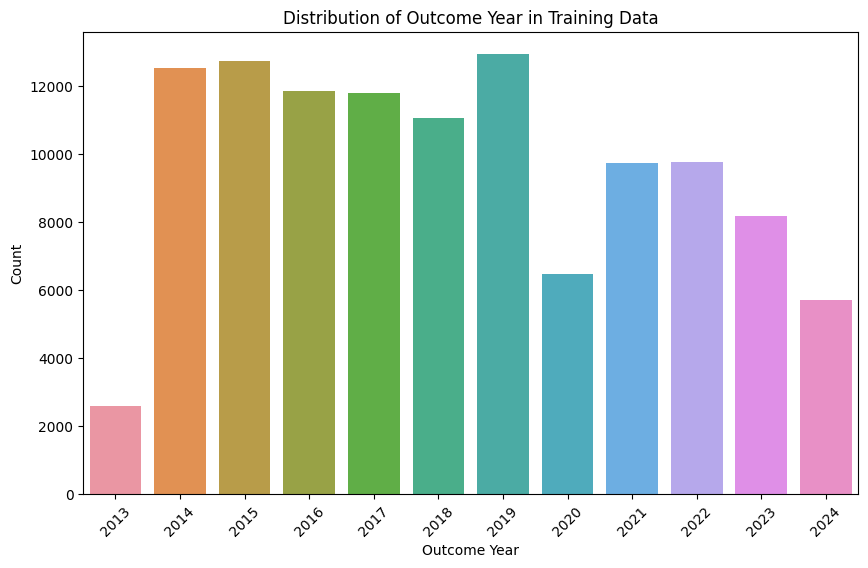

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
intake_year_dist = X_train['Outcome.Year'].value_counts().sort_index()

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=intake_year_dist.index, y=intake_year_dist.values)
plt.title('Distribution of Outcome Year in Training Data')
plt.xlabel('Outcome Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [10]:

# Step 5: Build the model
# Using RandomForestClassifier as an example
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_proba = rf_classifier.predict_proba(X_test)


In [11]:
y_pred_proba

array([[0.13, 0.3 , 0.27, ..., 0.  , 0.  , 0.  ],
       [0.31, 0.26, 0.2 , ..., 0.  , 0.  , 0.  ],
       [0.37, 0.24, 0.15, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.08, 0.35, 0.34, ..., 0.  , 0.  , 0.  ],
       [0.02, 0.46, 0.26, ..., 0.  , 0.  , 0.  ],
       [0.22, 0.35, 0.26, ..., 0.02, 0.  , 0.  ]])

In [12]:
predicted_df = pd.DataFrame(y_pred_proba, columns=rf_model.classes_)


all_classes = np.arange(1, 16)  # Adjust as per your class range
for class_label in all_classes:
    if class_label not in predicted_df.columns:
        predicted_df[class_label] = 0.0  # Assign zero probability to missing classes

predicted_df = predicted_df[all_classes]  # Reorder DataFrame




y_pred_df = pd.DataFrame(predicted_df)


y_pred_df.insert(0, 'Animal.ID', y_test.index)

print(y_pred_df.head())


  Animal.ID     1     2     3      4     5     6      7     8    9   10   11  \
0     15801  0.13  0.30  0.27  0.244  0.01  0.01  0.026  0.01  0.0  0.0  0.0   
1     15932  0.31  0.26  0.20  0.190  0.03  0.00  0.010  0.00  0.0  0.0  0.0   
2     28859  0.37  0.24  0.15  0.200  0.03  0.01  0.000  0.00  0.0  0.0  0.0   
3     30812  0.19  0.29  0.26  0.190  0.04  0.01  0.020  0.00  0.0  0.0  0.0   
4     30812  0.18  0.28  0.32  0.190  0.02  0.00  0.010  0.00  0.0  0.0  0.0   

    12   13   14   15  
0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  


In [13]:


y_test_df = pd.DataFrame({
    'Animal.ID': y_test.index,
    'Outcome.Type':  y_test.values   # No need for inverse mapping
})

print(y_test_df)

     Animal.ID  Outcome.Type
0        15801             3
1        15932             3
2        28859             3
3        30812            12
4        30812             3
...        ...           ...
9411     64574             3
9412     64582             3
9413     64584             3
9414     64588            12
9415     64608            13

[9416 rows x 2 columns]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import numpy as np
import pandas as pd

def scoring_function(y_pred_df, y_test_df, all_classes=None):
    '''
    Calculates various performance metrics for the predictions.

    Parameters:
    y_pred_df: DataFrame containing predictions.
    y_test_df: DataFrame containing true labels.
    all_classes: List of all possible classes.

    Returns:
    metrics: Dictionary containing accuracy, precision, recall, f1 score, and log loss.
    '''

    # Merge the prediction and actual outcome dataframes using Animal ID
    df_combined = pd.merge(y_pred_df, y_test_df, on='Animal.ID')

    if df_combined.empty:
        print("No data in the combined DataFrame.")
        return None

    # Convert the predicted probabilities into predicted classes (argmax)
    y_pred_class = df_combined.iloc[:, 1:-1].idxmax(axis=1).astype(int)
    y_true = df_combined['Outcome.Type'].astype(int)

    # If all_classes is None, use unique classes from y_true
    if all_classes is None:
        all_classes = np.unique(y_true)  # Get unique classes from y_true

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_class)

    # Calculate metrics only for predicted classes
    unique_pred_classes = np.unique(y_pred_class)
    precision = precision_score(y_true, y_pred_class, average='weighted', zero_division=0, labels=unique_pred_classes)
    recall = recall_score(y_true, y_pred_class, average='weighted', zero_division=0, labels=unique_pred_classes)
    f1 = f1_score(y_true, y_pred_class, average='weighted', zero_division=0, labels=unique_pred_classes)

    # Ensure that y_pred_probs contains probabilities for all classes
    y_pred_probs = df_combined.iloc[:, 1:-1].values

    # Create an array to ensure all classes are represented in predictions
    complete_probs = np.zeros((y_pred_probs.shape[0], len(all_classes)))  # Initialize with zeros
    for i, class_label in enumerate(all_classes):
        if class_label in df_combined.columns:
            complete_probs[:, i] = y_pred_probs[:, class_label - 1]  # Fill with actual probabilities

    # Calculate log loss with all classes present in the labels
    logloss = log_loss(y_true, complete_probs, labels=all_classes)

    # Print the metrics
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # Return the metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'log_loss': logloss
    }


In [15]:
 scoring_function(y_pred_df, y_test_df)


Accuracy: 0.1413
Precision: 0.5002
Recall: 0.2431
F1 Score: 0.2891
Log Loss: 15.3807


/dskh/nobackup/lijiay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


{'accuracy': 0.14132903071590774,
 'precision': 0.5002181868810497,
 'recall': 0.24306269270298048,
 'f1_score': 0.2890884416507159,
 'log_loss': 15.380741466729571}

In [16]:

# Evaluate the model
# print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Optionally, use RFE (Recursive Feature Elimination) for feature selection
# rfe = RFE(rf_classifier, n_features_to_select=10)  # Select top 10 features
# rfe.fit(X_train, y_train)

# # Show the selected features
# print("Selected features by RFE:")
# print(X_train.columns[rfe.support_])

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, classification_report

# Step 1: Standardize the data (PCA often requires scaling)
# scaler = StandardScaler()

# # Fit the scaler on the training data only and then transform both training and test sets
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Step 2: Perform PCA on the training data only
pca = PCA(n_components=0.95)  # Retain 95% variance or set a fixed number of components

# Fit PCA on the training data only
X_train_pca = pca.fit_transform(X_train)

# Transform the test data using the PCA model fitted on the training data
X_test_pca = pca.transform(X_test)

# Step 3: Train the model using the PCA-transformed training data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_pca, y_train)

# Step 4: Predict probabilities on the PCA-transformed test set
y_pred_proba = rf_classifier.predict_proba(X_test_pca)

In [18]:
predicted_df = pd.DataFrame(y_pred_proba, columns=rf_model.classes_)


all_classes = np.arange(1, 16)  # Adjust as per your class range
for class_label in all_classes:
    if class_label not in predicted_df.columns:
        predicted_df[class_label] = 0.0  # Assign zero probability to missing classes

predicted_df = predicted_df[all_classes]  # Reorder DataFrame



In [19]:
predicted_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.112619,0.000000,0.810000,0.000000,0.000000,0.077381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.015000,0.207008,0.517095,0.260897,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.185413,0.131444,0.644888,0.000000,0.021323,0.016931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.304783,0.655631,0.039586,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.304783,0.655631,0.039586,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9411,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9412,0.070380,0.080829,0.773847,0.000000,0.074943,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9413,0.401760,0.100281,0.465312,0.011114,0.005908,0.015626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9414,0.000000,0.246065,0.753935,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:

y_pred_df = pd.DataFrame(predicted_df)


y_pred_df.insert(0, 'Animal.ID', y_test.index)

print(y_pred_df.head())


  Animal.ID         1         2         3         4         5         6    7  \
0     15801  0.112619  0.000000  0.810000  0.000000  0.000000  0.077381  0.0   
1     15932  0.015000  0.207008  0.517095  0.260897  0.000000  0.000000  0.0   
2     28859  0.185413  0.131444  0.644888  0.000000  0.021323  0.016931  0.0   
3     30812  0.304783  0.655631  0.039586  0.000000  0.000000  0.000000  0.0   
4     30812  0.304783  0.655631  0.039586  0.000000  0.000000  0.000000  0.0   

     8    9   10   11   12   13   14   15  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  


In [21]:
y_test_df = pd.DataFrame({
    'Animal.ID': y_test.index,
    'Outcome.Type':  y_test.values   # No need for inverse mapping
})

print(y_test_df)

     Animal.ID  Outcome.Type
0        15801             3
1        15932             3
2        28859             3
3        30812            12
4        30812             3
...        ...           ...
9411     64574             3
9412     64582             3
9413     64584             3
9414     64588            12
9415     64608            13

[9416 rows x 2 columns]


In [22]:
scoring_function(y_pred_df, y_test_df)


Accuracy: 0.4316
Precision: 0.5218
Recall: 0.7422
F1 Score: 0.6122
Log Loss: 15.4490


/dskh/nobackup/lijiay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


{'accuracy': 0.43157643121787975,
 'precision': 0.5218178633608688,
 'recall': 0.74224049331963,
 'f1_score': 0.6122475885979418,
 'log_loss': 15.449023992465671}